<a href="https://colab.research.google.com/github/emilstahl97/Scalable-Machine-Learning-and-Deep-Learning-ID2223/blob/dev/finished_lab2_id2223.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Scalable Machine Learning and Deep Learning - Lab 2**

By:

Erik Kongpachith,
Emil Ståhl, and
Selemawit Fsha Nguse

Date: December 17th, 2021

The goal of this assignment is to train a network to produce sentence embedding, by implementing the proposed method of the Sentence-BERT (S-BERT) paper. In this lab we download and prepare data, fine-tune a pre-trained Transformer network, and finally evaluate on the official Semantic Textual Similarity (STS) benchmark. 

1. S-BERT Regression Objective
2. S-BERT Classificatiob Objective
3. Semantic Search System

Add dependencies to PIP

In [55]:
!pip install sentence_transformers
!pip install transformers
!pip install tokenizers
!pip install torch
!pip install wget
!pip install pyspark

Import libraries

In [89]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer

import torch
import string
import numpy as np
import json
import tensorflow as tf
import re
import scipy
import wget
import pandas as pd
import sklearn
import math
import os
import csv

from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from sentence_transformers import SentenceTransformer
from sentence_transformers import LoggingHandler
from sentence_transformers import models, losses, util
from sentence_transformers.readers import InputExample
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader
from transformers import BertTokenizer, TFBertModel, BertConfig
from tokenizers import BertWordPieceTokenizer

**Mount Google Drive to load saved models**

In [57]:
# README - Execute this cell to mount the notebook in your google drive. 
# Execute the cell and follow the link to sign and, paste the given key in the little text box. The credentials are only available for you. 

import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

if not os.path.exists("/content/drive/MyDrive/stsbenchmark"):
  print("Dataset does not exists, pullinng repository...") 
  os.mkdir("/content/drive/MyDrive/stsbenchmark")
  os.chdir("/content/drive/MyDrive/stsbenchmark")
  !git clone https://github.com/emilstahl97/stsbenchmark.git
  !git pull
else:
  print("Dataset exists")
  os.chdir("/content/drive/MyDrive/stsbenchmark")

# from GitHub repository
train_path = "/content/drive/MyDrive/stsbenchmark/stsbenchmark/sts-train.csv"
test_path = "/content/drive/MyDrive/stsbenchmark/stsbenchmark/sts-test.csv"
dev_path = "/content/drive/MyDrive/stsbenchmark/stsbenchmark/sts-dev.csv"

news_path = "/content/drive/MyDrive/stsbenchmark/stsbenchmark/news.csv"

# saved models
if not os.path.exists("/content/drive/MyDrive/id2223/lab2/models"):
  print("/models does not exists, creating...")
  os.makedirs("/content/drive/MyDrive/id2223/lab2/models")

if not os.path.exists("/content/drive/MyDrive/id2223/lab2/results"):
  print("/results does not exists, creating...")
  os.makedirs("/content/drive/MyDrive/id2223/lab2/results/regression_results/")


regression_model_path = "/content/drive/MyDrive/id2223/lab2/models/regression_model"
regression_results_path = "/content/drive/MyDrive/id2223/lab2/models/regression_results"
classification_model_path = '/content/drive/MyDrive/stsbenchmark/stsbenchmark/models/training_snli'

Mounted at /content/drive
Dataset exists


## **1. S-BERT REGRESSION OBJECTIVE**

The regression loss functions, takes into account the cosine-similarity between two sentence embedding. Hence, allowing us to directly tune the distance of the generated sentence embedding. The official STS training dataset can be found here: STSBenchmark
Since cosine-similarity is always in the range [−1, 1], we can set the most similar sentences to have a similarity of 1, and the most dissimilar to have −1. Sentence pairs with an intermediate label can easily be linearly mapped into this range, to get their target regression label. 

In [58]:
word_embedding_model = models.Transformer('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [59]:
train_samples = []
test_samples = []
dev_samples = []

columns = ['title', 'type', 'year', 'id', 'score', 'sentence_1', 'sentence_2']
paths = {"train": train_path, "test": test_path, "dev": dev_path}

for key, path in paths.items():
  with open(path, newline='') as f:
    temp = csv.DictReader(f, delimiter='\t', fieldnames=columns, quoting=csv.QUOTE_NONE)
    for row in temp:
        score = float(row['score']) / 2.5 - 1 
        input_example = InputExample(texts=[row['sentence_1'], row['sentence_2']], label=score)
        if (key == "train"):
          train_samples.append(input_example)
        elif key == "test":
          test_samples.append(input_example)
        elif key == "dev":
          dev_samples.append(input_example)
        else:
          raise Exception(f"key {key} not known, exiting")

In [60]:
train_batch_size = 16
learn_rate = 2e-5
num_epochs = 1

Mean-pooling strategy

In [61]:
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

In [62]:
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [63]:
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)

In [64]:
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, batch_size=train_batch_size, name='sts-dev')

10% of train dataset for warm-up

In [65]:
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)

**Training**

In [66]:
if os.path.exists(regression_model_path):
    print("Loading pre-trained model")
    model = SentenceTransformer(regression_model_path)
else:
    print("Re-training model")
    model = model.fit(train_objectives=[(train_dataloader, train_loss)],
                    optimizer_class=torch.optim.Adam,
                    optimizer_params={'lr': learn_rate},
                    evaluator=evaluator,
                    epochs=num_epochs,
                    evaluation_steps=1000,
                    warmup_steps=warmup_steps,
                    output_path=regression_model_path)

Loading pre-trained model


##**Evaluation on STS benchmark dataset**

Evaluation of Semantic Sentence Embedding is usually done by ranking a set of sentence pairs in term of similarity, then comparing the produced ranking with that of humans. The metric used to compare two sets of rankings is the Spearmean Correlation.

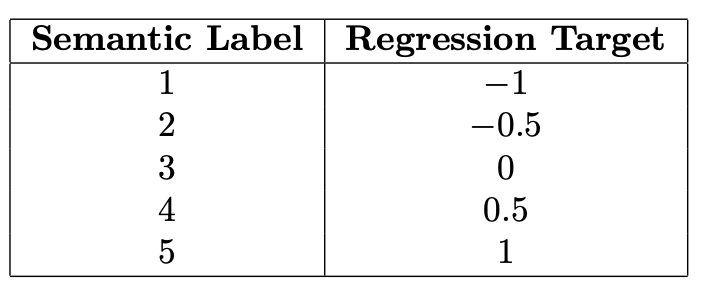

In [67]:
test_eval = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, batch_size=train_batch_size, name='sts-test')
c_s = test_eval(model, output_path=regression_results_path)
print('Cosine similarity: ', c_s)

Cosine similarity:  0.5263565694181714


Embedding sentences

In [68]:
df_test = pd.read_csv(test_path, sep='\t', header=None, error_bad_lines=False, quoting=csv.QUOTE_NONE)
df_test.columns = columns

b'Skipping line 626: expected 7 fields, saw 9\nSkipping line 627: expected 7 fields, saw 9\nSkipping line 628: expected 7 fields, saw 9\nSkipping line 629: expected 7 fields, saw 9\nSkipping line 630: expected 7 fields, saw 9\nSkipping line 631: expected 7 fields, saw 9\nSkipping line 632: expected 7 fields, saw 9\nSkipping line 633: expected 7 fields, saw 9\nSkipping line 634: expected 7 fields, saw 9\nSkipping line 635: expected 7 fields, saw 9\nSkipping line 636: expected 7 fields, saw 9\nSkipping line 637: expected 7 fields, saw 9\nSkipping line 638: expected 7 fields, saw 9\nSkipping line 639: expected 7 fields, saw 9\nSkipping line 640: expected 7 fields, saw 9\nSkipping line 641: expected 7 fields, saw 9\nSkipping line 642: expected 7 fields, saw 9\nSkipping line 643: expected 7 fields, saw 9\nSkipping line 644: expected 7 fields, saw 9\nSkipping line 645: expected 7 fields, saw 9\nSkipping line 646: expected 7 fields, saw 9\nSkipping line 647: expected 7 fields, saw 9\nSkipping

In [69]:
embed_1 = model.encode(df_test['sentence_1'], convert_to_numpy=True, batch_size=train_batch_size)
embed_2 = model.encode(df_test['sentence_2'], convert_to_numpy=True, batch_size=train_batch_size)

Compute the cosine similarity

In [70]:
cosine_similarity = 1 - sklearn.metrics.pairwise.paired_cosine_distances(embed_1, embed_2)
print('Cosine similarity = ', cosine_similarity)

Cosine similarity =  [0.27117753 0.8809062  0.58966494 ... 0.74274147 0.85241306 0.9187385 ]


Spearmean correlation coefficient

In [71]:
spr_corr = scipy.stats.spearmanr(cosine_similarity, df_test['score'])
print('Spearmean correlation coefficient = ', spr_corr[0])

Spearmean correlation coefficient =  0.534628805412517


## *2. S-BERT CLASSIFICATION OBJECTIVE*

In [72]:
print('Downloading snil: ')
wget.download('https://nlp.stanford.edu/projects/snli/snli_1.0.zip', './snli_1.0.zip')
!unzip snli_1.0.zip

Archive:  snli_1.0.zip
replace snli_1.0/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: snli_1.0/.DS_Store      
  inflating: __MACOSX/snli_1.0/._.DS_Store  
 extracting: snli_1.0/Icon           
  inflating: __MACOSX/snli_1.0/._Icon  
  inflating: snli_1.0/README.txt     
  inflating: __MACOSX/snli_1.0/._README.txt  
  inflating: snli_1.0/snli_1.0_dev.jsonl  
  inflating: snli_1.0/snli_1.0_dev.txt  
  inflating: snli_1.0/snli_1.0_test.jsonl  
  inflating: snli_1.0/snli_1.0_test.txt  
  inflating: snli_1.0/snli_1.0_train.jsonl  
  inflating: snli_1.0/snli_1.0_train.txt  
  inflating: __MACOSX/._snli_1.0     


In [73]:
spark = SparkSession.builder.getOrCreate()
train_class_path = 'snli_1.0/snli_1.0_train.jsonl'
train_class = spark.read.json(train_class_path)

test_class_path = 'snli_1.0/snli_1.0_test.jsonl'
test_class = spark.read.json(test_class_path)

dev_class_path = 'snli_1.0/snli_1.0_dev.jsonl'
dev_class = spark.read.json(dev_class_path)

In [74]:
indexer = StringIndexer(inputCol="gold_label", outputCol="label")
def CreateSamples(df):
    samples = []
    for _, row in df.iterrows():
        input_example = InputExample(texts=[row['sentence1'], row['sentence2']], label=row['label'])
        samples.append(input_example)
    return samples
    
def CreateSampleClass(df):
    df = df.filter(col("gold_label") != "-")
    df = indexer.fit(df).transform(df)
    df = df.withColumn("label", col("label").cast('int'))

    df_class = df.select("sentence1", "sentence2", "label").toPandas()

    return CreateSamples(df_class)

In [75]:
train_class_samples = CreateSampleClass(train_class)
test_class_samples = CreateSampleClass(test_class)
dev_class_samples = CreateSampleClass(dev_class)

In [76]:
train_dataloader_cl = DataLoader(train_class_samples, shuffle=True, batch_size=train_batch_size)
num_lables = test_class.select('annotator_labels').distinct().count()
train_loss_cl = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=num_lables)

In [77]:
evaluator_cl = EmbeddingSimilarityEvaluator.from_input_examples(dev_class_samples, batch_size=train_batch_size, name='snli-dev')
warmup_steps_cl = math.ceil(len(train_dataloader) * num_epochs * 0.1)

In [78]:
if os.path.exists(classification_model_path):
    print("Loading pre-trained model")
    model = SentenceTransformer(classification_model_path)
else:
    print("Retraining model")
    model.fit(train_objectives=[(train_dataloader_cl, train_loss_cl)],
             evaluator=evaluator_cl,
             epochs=num_epochs,
             evaluation_steps=1000,
             warmup_steps=warmup_steps_cl,
             output_path=classification_model_path)

Loading pre-trained model


In [79]:
evaluation_class_location = "./classification"

if not os.path.exists(evaluation_class_location):
    os.makedirs(evaluation_class_location)

test_eval_cl = EmbeddingSimilarityEvaluator.from_input_examples(test_class_samples, batch_size=train_batch_size, name='snli-test')
c_s_cl = test_eval_cl(model, output_path=evaluation_class_location)
print('Cosine similarity with the sentence_transformers library = ', c_s_cl)

Cosine similarity with the sentence_transformers library =  -0.10038784683009352


In [80]:
c_s_sts = test_eval(model, output_path=evaluation_class_location)
print('Cosine similarity with the sentence_transformers library = ', c_s_sts)

Cosine similarity with the sentence_transformers library =  0.7053019304518711


In [81]:
embed_1_snli = model.encode(df_test['sentence_1'], convert_to_numpy=True, batch_size=train_batch_size)
embed_2_snli = model.encode(df_test['sentence_2'], convert_to_numpy=True, batch_size=train_batch_size)

embed_1 = model.encode(df_test['sentence_1'], convert_to_numpy=True, batch_size=train_batch_size)
embed_2 = model.encode(df_test['sentence_2'], convert_to_numpy=True, batch_size=train_batch_size)

In [82]:
cos_sim_cl = 1 - sklearn.metrics.pairwise.paired_cosine_distances(embed_1_snli, embed_2_snli)
print('SNLI-test: cosine similarity = ', cos_sim_cl)

cos_sim_sts = 1 - sklearn.metrics.pairwise.paired_cosine_distances(embed_1, embed_2)
print('STS benchmark: cosine similarity = ', cos_sim_sts)

SNLI-test: cosine similarity =  [0.9438066  0.98536867 0.9574722  ... 0.92456174 0.97644114 0.9765778 ]
STS benchmark: cosine similarity =  [0.9438066  0.98536867 0.9574722  ... 0.92456174 0.97644114 0.9765778 ]


In [83]:
spr_corr_cl = scipy.stats.spearmanr(cos_sim_cl, df_test['score'])
print('SNLI-test: Spearmean correlation coefficient = ', spr_corr_cl[0])

spr_corr_sts = scipy.stats.spearmanr(cos_sim_sts, df_test['score'])
print('STS benchmark: Spearmean correlation coefficient = ', spr_corr_sts[0])

SNLI-test: Spearmean correlation coefficient =  0.7466708047140973
STS benchmark: Spearmean correlation coefficient =  0.7466708047140973


##**3. Semantic Search**

Finally, we will create something useful of our sentence embedding model. Recall that an embedding is only a high-dimensional vector. This makes searching for nearby embedding, and thus semantically similar sentences, very effective. In particular, one can take a text corpus and pre-compute sentence embedding for all sentences. So that when the user enters a search string, we only need to compute the sentence embedding of the search query.

We use a subset of 10.000 headdlines from the following dataset: 

[A Million News Headlines](https://www.kaggle.com/therohk/million-headlines)

In [84]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [85]:
# Import the data, remove the first row ie the header and dates
df = pd.read_csv(news_path, sep =",", error_bad_lines=False, names = ["Date", "Sentence"], nrows=10000)
df = df.iloc[1: , :]
df.drop(['Date'], axis=1, inplace = True)
df.head(10)

,Sentence
1,aba decides against community broadcasting lic...
2,act fire witnesses must be aware of defamation
3,a g calls for infrastructure protection summit
4,air nz staff in aust strike for pay rise
5,air nz strike to affect australian travellers
6,ambitious olsson wins triple jump
7,antic delighted with record breaking barca
8,aussie qualifier stosur wastes four memphis match
9,aust addresses un security council over iraq
10,australia is locked into war timetable opp


In [86]:
# Compute the cosine similarity between the search sentences and the sentences from data, return the indexes of the k most similar sentences

values = list() #For saving the highest cosine similarity 

# Compute the cosine similarity between the search sentences and the sentences from data, return the indexes of the k most similar sentences
def search(search_sentences_embedding, sentence_embeddings):
    similarity_matrix = cosine_similarity(search_sentences_embedding, sentence_embeddings[:])
    similarities = similarity_matrix[0]
    indexes = similarities.argsort()[-k:][::1]

    for idx in indexes:
      values.append(similarity_matrix[0][idx])

    return indexes

In [93]:
sentences = df.iloc[:, 0] # Get the sentences from the data

sentence_embeddings= model.encode(sentences.values) # do embedding for the sentences from the data

In [94]:
search_sentence_embedding = model.encode(["kallis out of bangladesh"]) #Embedd the search sentence

k = 10 # number of similar sentences to include in the result
similar_sentences = search(search_sentence_embedding, sentence_embeddings) #get indexes for the most similar sentences

In [95]:
# Print out the K most similar sentences
i=0
for idx in similar_sentences:
    print(sentences[idx], values[i])
    i = i+1

bhp steel records 242m half year profit 0.56791115
witnesses identify nightclub drive by shooters 0.5750314
dengue outbreak hits more suburbs 0.57561827
brogden urges voters to throw labor out 0.5775241
nt health minister calls for meeting with cwealth 0.5862519
pakistan to push icc on india boycott 0.59333616
powell starts asian tour for north korea talks 0.59625375
hollywood refusing to promote war 0.59745204
bali suspect yells support for iraq 0.73081243
japanese whaling fleet returns home with catch 0.8585953


##**End**